## NLP project

Read all data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
train_data = pd.read_csv('train.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
dev_data = pd.read_csv('dev.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
test_data = pd.read_csv('test.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])

<BarContainer object of 5 artists>

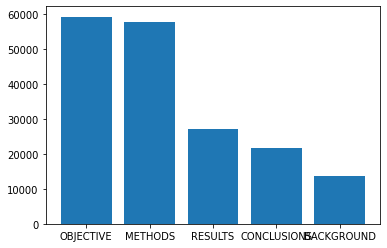

In [3]:
labels = train_data['label'].unique()

plt.bar(labels, train_data['label'].value_counts())

In [4]:
import spacy
import nltk
# import ssl
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context
nltk.download()
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

nlp = spacy.load('en_core_web_sm')

/home/changhyun/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


2022-06-28 21:53:39.381741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/changhyun/catkin_ws/devel/lib
2022-06-28 21:53:39.381767: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/changhyun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/changhyun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/changhyun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/changhyun/nltk_data...
[nltk_data]   Package averaged_perceptron_ta

In [5]:
# Cleaning process such that replacing punctuation to space, deleting them, or making them lowercase

def clean_text(text):
    
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text


### First model: Random Forest 


In [6]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [15]:
stopWords = set(stopwords.words('english'))

bow_vec = CountVectorizer(ngram_range=(1,1), stop_words=stopWords, tokenizer=word_tokenize, max_features=1000)
bow_vec.fit(raw_documents=train_data['txt'].tolist())
X_train = bow_vec.transform(train_data['txt'])
X_devel = bow_vec.transform(dev_data['txt'])
X_test = bow_vec.transform(test_data['txt'])

y_train = train_data['label']
y_devel = dev_data['label']
y_test = test_data['label']

/home/changhyun/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/changhyun/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [16]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=random_seed)
for first_index, second_index in skf.split(X_train, y_train):
    X_train_f, X_train_s = X_train[first_index], X_train[second_index]
    y_train_f, y_train_s = y_train[first_index], y_train[second_index]

rf = RandomForestClassifier(n_estimators=100, random_state=random_seed, n_jobs=-1)
rf.fit(X_train_f, y_train_f)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [17]:
y_pred = rf.predict(X_devel)
print(classification_report(y_devel, y_pred))

              precision    recall  f1-score   support

  BACKGROUND       0.55      0.48      0.51      3449
 CONCLUSIONS       0.65      0.58      0.61      4582
     METHODS       0.76      0.87      0.81      9964
   OBJECTIVE       0.62      0.45      0.52      2376
     RESULTS       0.81      0.82      0.82      9841

    accuracy                           0.73     30212
   macro avg       0.68      0.64      0.65     30212
weighted avg       0.72      0.73      0.73     30212



In [23]:
train_text_cleaned = train_data['txt'].apply(clean_text)
devel_text_cleaned = dev_data['txt'].apply(clean_text)
test_text_cleaned = test_data['txt'].apply(clean_text)

In [27]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,1), tokenizer=word_tokenize, stop_words=stopWords, max_features=1000)
tfidf_vec.fit(train_text_cleaned.tolist())

# X_train = tfidf_vec.transform(train_data['txt'])
# X_devel = tfidf_vec.transform(dev_data['txt'])
# X_test = tfidf_vec.transform(test_data['txt'])

X_train = tfidf_vec.transform(train_text_cleaned)
X_devel = tfidf_vec.transform(devel_text_cleaned)
X_test = tfidf_vec.transform(test_text_cleaned)

In [30]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
for first_index, second_index in skf.split(X_train, y_train):
    X_train_f, X_train_s = X_train[first_index], X_train[second_index]
    y_train_f, y_train_s = y_train[first_index], y_train[second_index]

rf2 = RandomForestClassifier(n_estimators=100, random_state=random_seed, n_jobs=-1)
rf2.fit(X_train_f, y_train_f)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [31]:
y_pred = rf2.predict(X_devel)
print(classification_report(y_devel, y_pred))

              precision    recall  f1-score   support

  BACKGROUND       0.55      0.48      0.51      3449
 CONCLUSIONS       0.61      0.57      0.59      4582
     METHODS       0.75      0.88      0.81      9964
   OBJECTIVE       0.64      0.46      0.53      2376
     RESULTS       0.81      0.80      0.81      9841

    accuracy                           0.73     30212
   macro avg       0.67      0.64      0.65     30212
weighted avg       0.72      0.73      0.72     30212



In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# from torchtext.data import Field, TabularDataset, BucketIterator


random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding()
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            n_layers=n_layers)
        
        self.fc = nn.Linear(2*dim, 1)
        
    def forward(self, text, text_len):
        